# Brent Oil Prices Forecast
## Importing the needed libraries

In [1]:
!pip install fbprophet

In [2]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from datetime import datetime
from datetime import timedelta
from time import time
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA    
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


## Creating some useful functions

In [3]:
def specific_time(df, start, end):
    time=(df['Date']>start) & (df['Date']<=end)
    df=df.loc[time]
    plt.figure(figsize=(10, 5))
    figure=sns.lineplot(x='Date', y='Price', data=df)

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [5]:
def test_stationarity(ts):
    
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
   
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['Price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## importing the data and preparing it

In [6]:
df=pd.read_csv('BrentOilPrices.csv')

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


<AxesSubplot:xlabel='Date', ylabel='Price'>

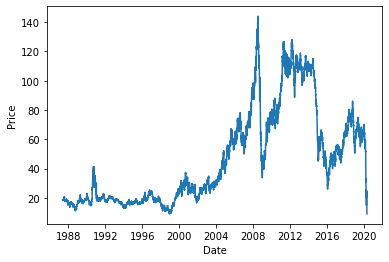

In [9]:
sns.lineplot(x='Date', y='Price', data=df)

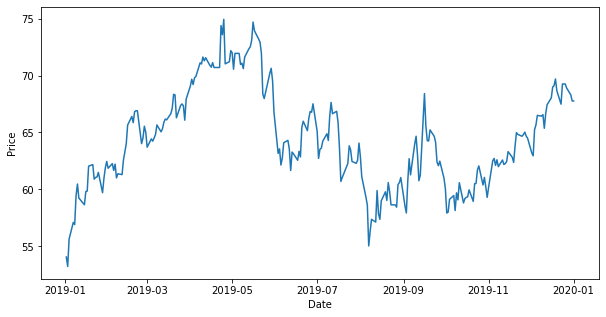

In [10]:
specific_time(df, '2019-01-01', '2020-01-01')

In [11]:
model_df=df
model_df.columns=['ds', 'y']
model_df.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## Forecasting Models 
#### 1- FB Prophet

In [12]:
model=Prophet(daily_seasonality=True)
model.fit(model_df)

In [13]:
model_forecast=model.make_future_dataframe(periods=0)
forecast=model.predict(model_forecast)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,17.745034,2.594405,31.570747,17.745034,17.745034,-0.589789,-0.589789,-0.589789,-1.764582,...,-0.150811,-0.150811,-0.150811,1.325603,1.325603,1.325603,0.0,0.0,0.0,17.155244
1,1987-05-21,17.748888,1.870675,31.747455,17.748888,17.748888,-0.437053,-0.437053,-0.437053,-1.764582,...,0.002577,0.002577,0.002577,1.324952,1.324952,1.324952,0.0,0.0,0.0,17.311835
2,1987-05-22,17.752743,3.398730,33.127777,17.752743,17.752743,-0.526190,-0.526190,-0.526190,-1.764582,...,-0.084195,-0.084195,-0.084195,1.322588,1.322588,1.322588,0.0,0.0,0.0,17.226554
3,1987-05-25,17.764308,3.544500,31.513738,17.764308,17.764308,-0.497686,-0.497686,-0.497686,-1.764582,...,-0.038401,-0.038401,-0.038401,1.305297,1.305297,1.305297,0.0,0.0,0.0,17.266622
4,1987-05-26,17.768163,2.367442,31.737203,17.768163,17.768163,-0.638702,-0.638702,-0.638702,-1.764582,...,-0.170316,-0.170316,-0.170316,1.296196,1.296196,1.296196,0.0,0.0,0.0,17.129461


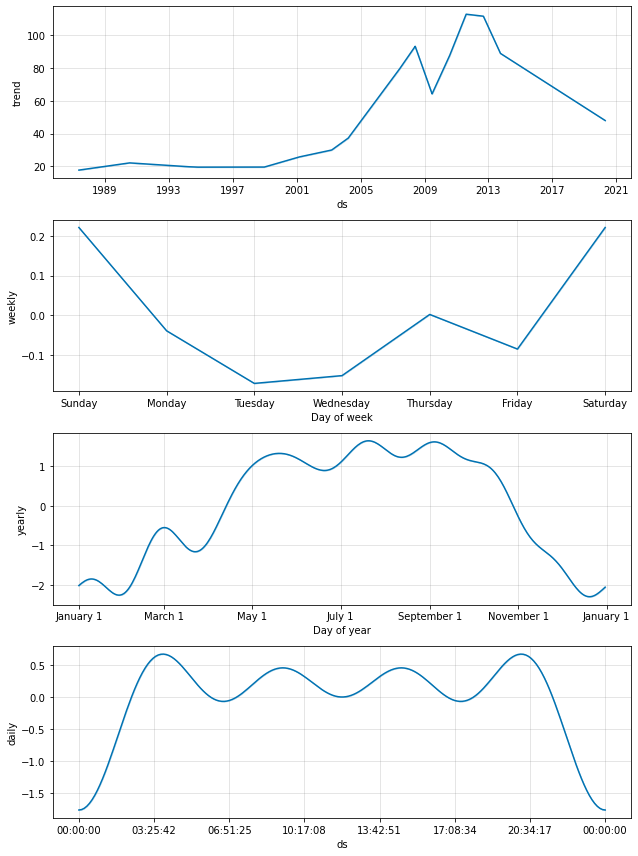

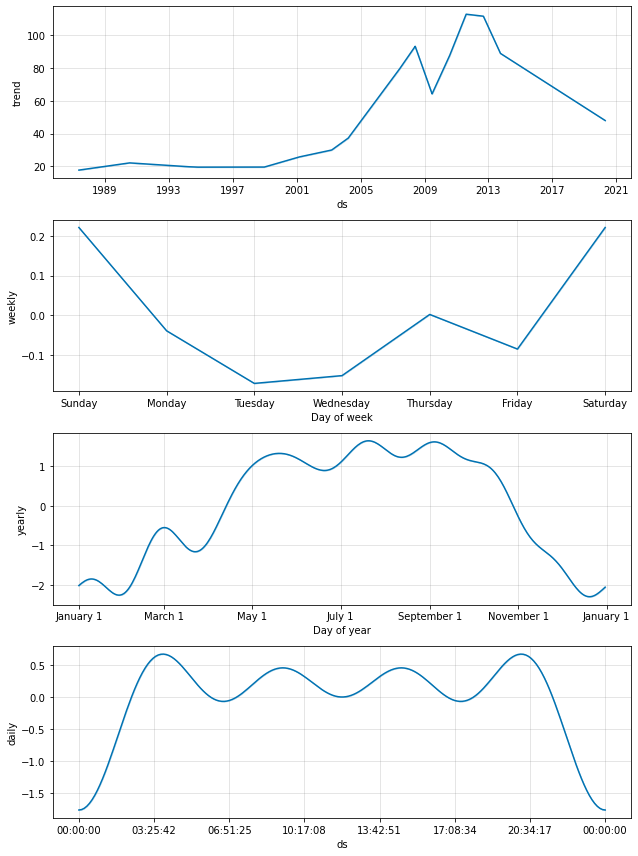

In [14]:
model.plot_components(forecast)

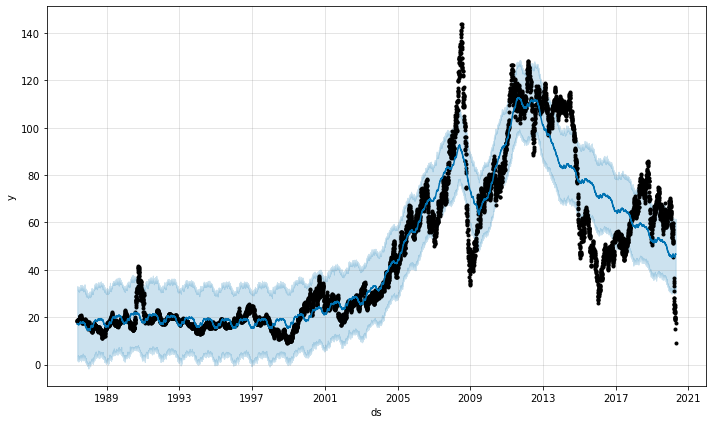

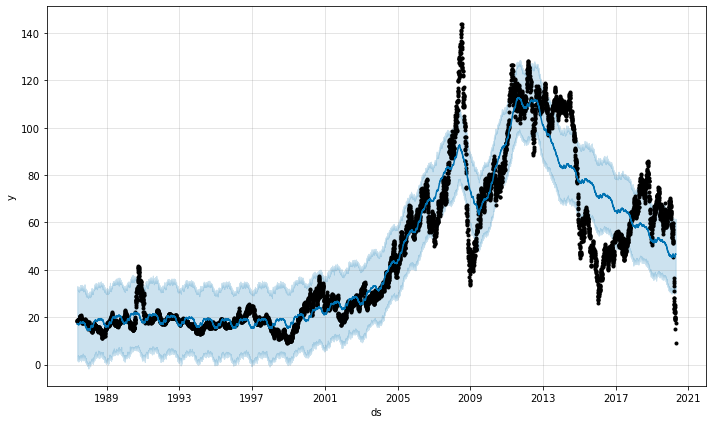

In [15]:
model.plot(forecast)

In [16]:
vis_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(model_df.set_index('ds'))

In [17]:
vis_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-04-15,46.392076,30.917468,60.865784,19.80
2020-04-16,46.600391,32.227227,61.052774,18.69
2020-04-17,46.566536,32.003788,60.827659,19.75
2020-04-20,46.757273,32.564910,61.191395,17.36
2020-04-21,46.668657,30.211477,61.483931,9.12


In [18]:
y_true=model_df['y']
y_predicted=vis_df['yhat']
mae=mean_absolute_error(y_true, y_predicted)
r2=r2_score(y_true, y_predicted)
mse=mean_squared_error(y_true, y_predicted)
print('prophet accuracy using mean absolute error=', mae)
print('prophet accuracy using mean squared error=', mse)
print('prophet accuracy using r2 score=', r2)

prophet accuracy using mean absolute error= 7.733817110984677
prophet accuracy using mean squared error= 132.603940401987
prophet accuracy using r2 score= 0.874478871878724


### 2) ARIMA 

In [19]:
ndf= pd.read_csv('modified_oil_prices.csv', parse_dates=[1], index_col=1, squeeze=True, date_parser=parser)

In [20]:
ndf.head()

,Unnamed: 0,Price
Date,,
1987-05-20,0,18.63
1987-05-21,1,18.45
1987-05-22,2,18.55
1987-05-25,3,18.60
1987-05-26,4,18.63


In [21]:
ndf.drop(['Unnamed: 0'], axis=1, inplace=True)

In [22]:
ndf.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


#### Setting the time series frequency to fit the data

In [23]:
ndf = ndf.asfreq(freq='B')

In [24]:
missing_data=ndf.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())

Price
False    8360
True      230
Name: Price, dtype: int64


In [25]:
ndf.fillna(method='bfill', inplace=True)
ndf.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [26]:
arima_df=ndf
arima_df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


#### Testing the the sationarity of the time series using Dicky-Fuller Test

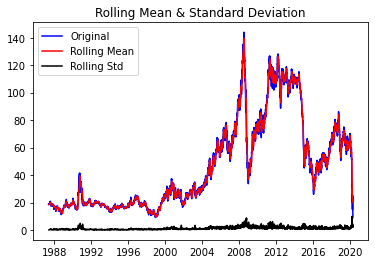

Results of Dickey-Fuller Test:
Test Statistic                   -2.001070
p-value                           0.286104
#Lags Used                       37.000000
Number of Observations Used    8552.000000
Critical Value (1%)              -3.431115
Critical Value (5%)              -2.861878
Critical Value (10%)             -2.566950
dtype: float64


In [27]:
test_stationarity(arima_df)

#### Trying the first difference to make the data stationary

In [28]:
first_diff = arima_df.diff()[1:]
first_diff.head()

,Price
Date,
1987-05-21,-0.18
1987-05-22,0.10
1987-05-25,0.05
1987-05-26,0.03
1987-05-27,-0.03


Text(0, 0.5, 'price')

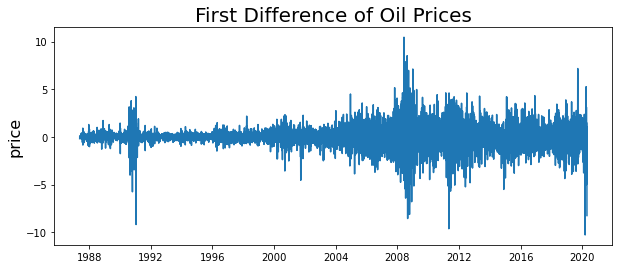

In [29]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Oil Prices', fontsize=20)
plt.ylabel('price', fontsize=16)

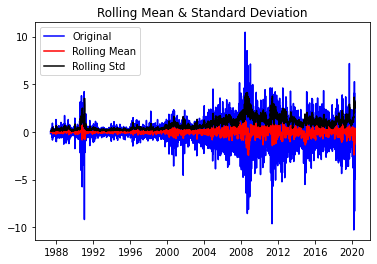

Results of Dickey-Fuller Test:
Test Statistic                -1.231574e+01
p-value                        6.928569e-23
#Lags Used                     3.600000e+01
Number of Observations Used    8.552000e+03
Critical Value (1%)           -3.431115e+00
Critical Value (5%)           -2.861878e+00
Critical Value (10%)          -2.566950e+00
dtype: float64


In [30]:
test_stationarity(first_diff)

#### plotting the acf and pacf to set the parameters for ARIMA 

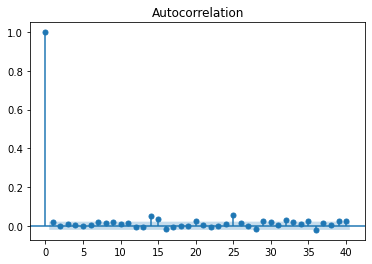

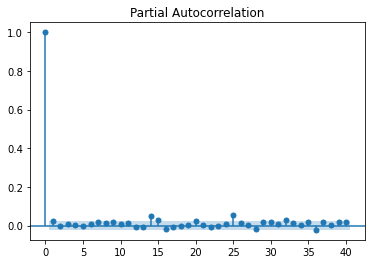

In [31]:
acf_plot=plot_acf(first_diff)
pacf_plot=plot_pacf(first_diff)

#### splitting the data to evaluate the model

In [32]:
train_end = datetime(2019,1,1)
test_end = datetime(2020,4,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]
test_data

,Price
Date,
2019-01-02,0.00
2019-01-03,-0.83
2019-01-04,2.41
2019-01-07,1.46
2019-01-08,-0.19
...,...
2020-03-26,-2.07
2020-03-27,-1.16
2020-03-30,-3.32


In [33]:
model1=ARIMA(train_data, order=(1,1,1))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [34]:
model_fit=model1.fit()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [35]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 8248
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12130.330
Method:                       css-mle   S.D. of innovations              1.053
Date:                Sat, 05 Dec 2020   AIC                          24268.659
Time:                        03:39:57   BIC                          24296.730
Sample:                    05-22-1987   HQIC                         24278.253
                         - 01-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.71e-06   5.01e-06     -0.342      0.733   -1.15e-05     8.1e-06
ar.L1.D.Price     0.0221      0.011      2.004      0.045       0.000       0.044
ma.L1.D.Price    -1.0000      0.000  -24

#### Forcasting using ARIMA

In [36]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [37]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
predictions

2019-01-02   -0.002753
2019-01-03   -0.000062
2019-01-04   -0.000003
2019-01-07   -0.000002
2019-01-08   -0.000002
                ...   
2020-03-26   -0.000002
2020-03-27   -0.000002
2020-03-30   -0.000002
2020-03-31   -0.000002
2020-04-01   -0.000002
Freq: B, Length: 326, dtype: float64

In [38]:
predictions=pd.DataFrame(predictions)
predictions.head()

,0
2019-01-02,-0.002753
2019-01-03,-0.000062
2019-01-04,-0.000003
2019-01-07,-0.000002
2019-01-08,-0.000002


In [39]:
headers=['predictions']
predictions.columns=headers
predictions.head()

,predictions
2019-01-02,-0.002753
2019-01-03,-0.000062
2019-01-04,-0.000003
2019-01-07,-0.000002
2019-01-08,-0.000002


In [40]:
predictions.index.names = ['Date']
predictions

,predictions
Date,
2019-01-02,-0.002753
2019-01-03,-0.000062
2019-01-04,-0.000003
2019-01-07,-0.000002
2019-01-08,-0.000002
...,...
2020-03-26,-0.000002
2020-03-27,-0.000002
2020-03-30,-0.000002


In [41]:
result=pd.merge(test_data, predictions, on='Date')
result.head()

,Price,predictions
Date,,
2019-01-02,0.00,-0.002753
2019-01-03,-0.83,-0.000062
2019-01-04,2.41,-0.000003
2019-01-07,1.46,-0.000002
2019-01-08,-0.19,-0.000002


In [42]:
result['residuals']=result['Price']-result['predictions']
result.head()

,Price,predictions,residuals
Date,,,
2019-01-02,0.00,-0.002753,0.002753
2019-01-03,-0.83,-0.000062,-0.829938
2019-01-04,2.41,-0.000003,2.410003
2019-01-07,1.46,-0.000002,1.460002
2019-01-08,-0.19,-0.000002,-0.189998


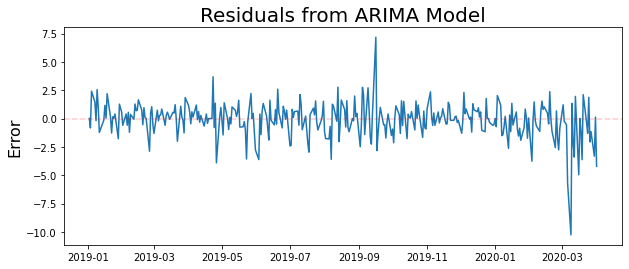

In [43]:
plt.figure(figsize=(10,4))
plt.plot(result['residuals'])
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [45]:
print('Root Mean Squared Error:', numpy.sqrt(numpy.mean(result['residuals']**2)))

Root Mean Squared Error: 1.5279537216688692


In [47]:
result['actual_price']=arima_df['Price']
result['predicted_price']=arima_df['Price']
for interval in range(0, len(result)-1):
    result['predicted_price'][interval+1]=result['predictions'][interval+1]+result['actual_price'][interval]
result.head()

,Price,predictions,residuals,actual_price,predicted_price
Date,,,,,
2019-01-02,0.00,-0.002753,0.002753,54.06,54.060000
2019-01-03,-0.83,-0.000062,-0.829938,53.23,54.059938
2019-01-04,2.41,-0.000003,2.410003,55.64,53.229997
2019-01-07,1.46,-0.000002,1.460002,57.10,55.639998
2019-01-08,-0.19,-0.000002,-0.189998,56.91,57.099998


Text(0, 0.5, 'Price')

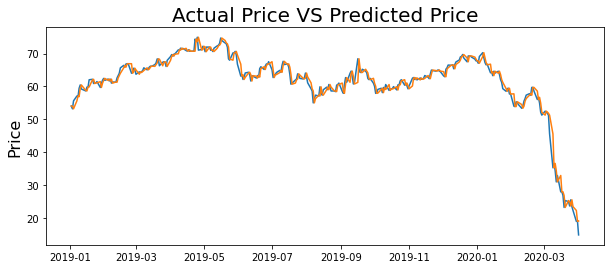

In [48]:
plt.figure(figsize=(10,4))
plt.plot(result['actual_price'])
plt.plot(result['predicted_price'])
plt.title('Actual Price VS Predicted Price', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [50]:
y_true=result['actual_price']
y_predicted=result['predicted_price']
mae=mean_absolute_error(y_true, y_predicted)
r2=r2_score(y_true, y_predicted)
mse=mean_squared_error(y_true, y_predicted)
print('ARIMA accuracy using mean absolute error=', mae)
print('ARIMA accuracy using mean squared error=', mse)
print('ARIMA accuracy using r2 score=', r2)

ARIMA accuracy using mean absolute error= 1.0607667888462902
ARIMA accuracy using mean squared error= 2.3346425523120553
ARIMA accuracy using r2 score= 0.9759763011083021


## Conclusion 

After Creating two models for oil price forecasting: 
1. FB Prophet 
  **Mean Squared Error of 132.6**
2. AutoRegressive Integrated Moving Average (ARIMA)
  **Mean Squared Error of 2.33**